# In this notebook, we try to visualize transmission tree

Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM
Initializing sim with 300 people for 60 days
Loading location-specific data for "Bangladesh"
  Running 2020-03-01 ( 0/60) (0.01 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.02 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.03 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.03 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.04 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (0.04 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (0.05 s)  •••••••••••••••••••• 100%

Simulation summary:
          304 cumulative infections
           49 cumulative reinfections
          297 cumulative infectious
          184 cumulative symptomatic cases
           12 cumulative severe cases
            0 cumulative critical cases
          278 cumulative recoveries
            0 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative 

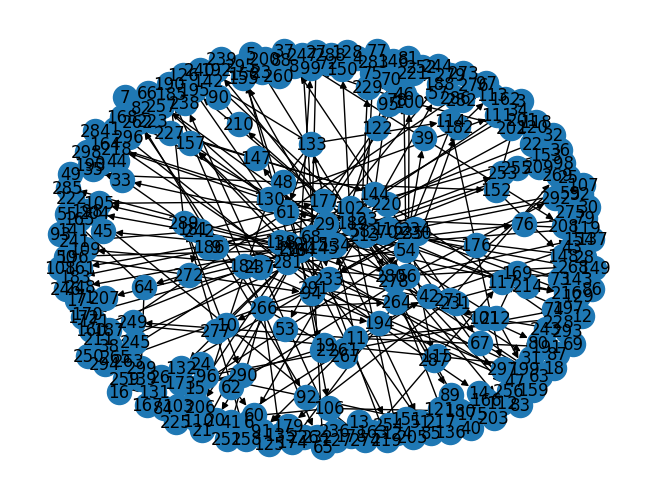

In [2]:
import covasim as cv
import networkx as nx
import matplotlib.pyplot as plt

pars = dict(
    pop_size = 300, 
    pop_type = 'hybrid',
    location = 'Bangladesh')

sim = cv.Sim(pars).run()
trans_tree = sim.make_transtree(to_networkx=True)
nx.draw(trans_tree.graph, with_labels = True, pos=nx.spring_layout(trans_tree.graph))
plt.show()

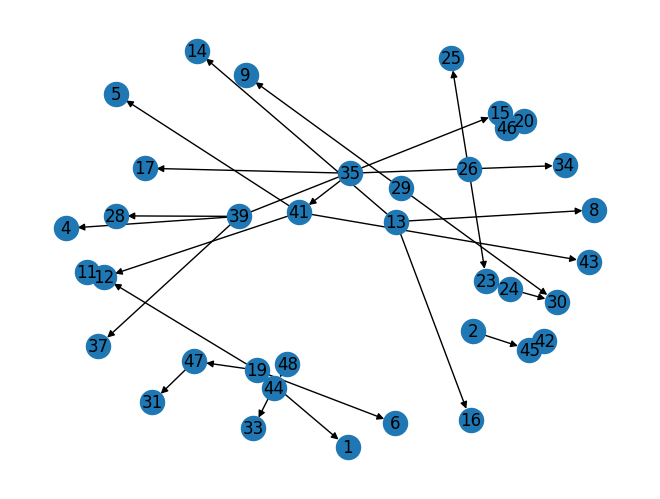

In [73]:
nx.draw(temp, with_labels = True)#, pos=nx.spring_layout(temp))
plt.show()

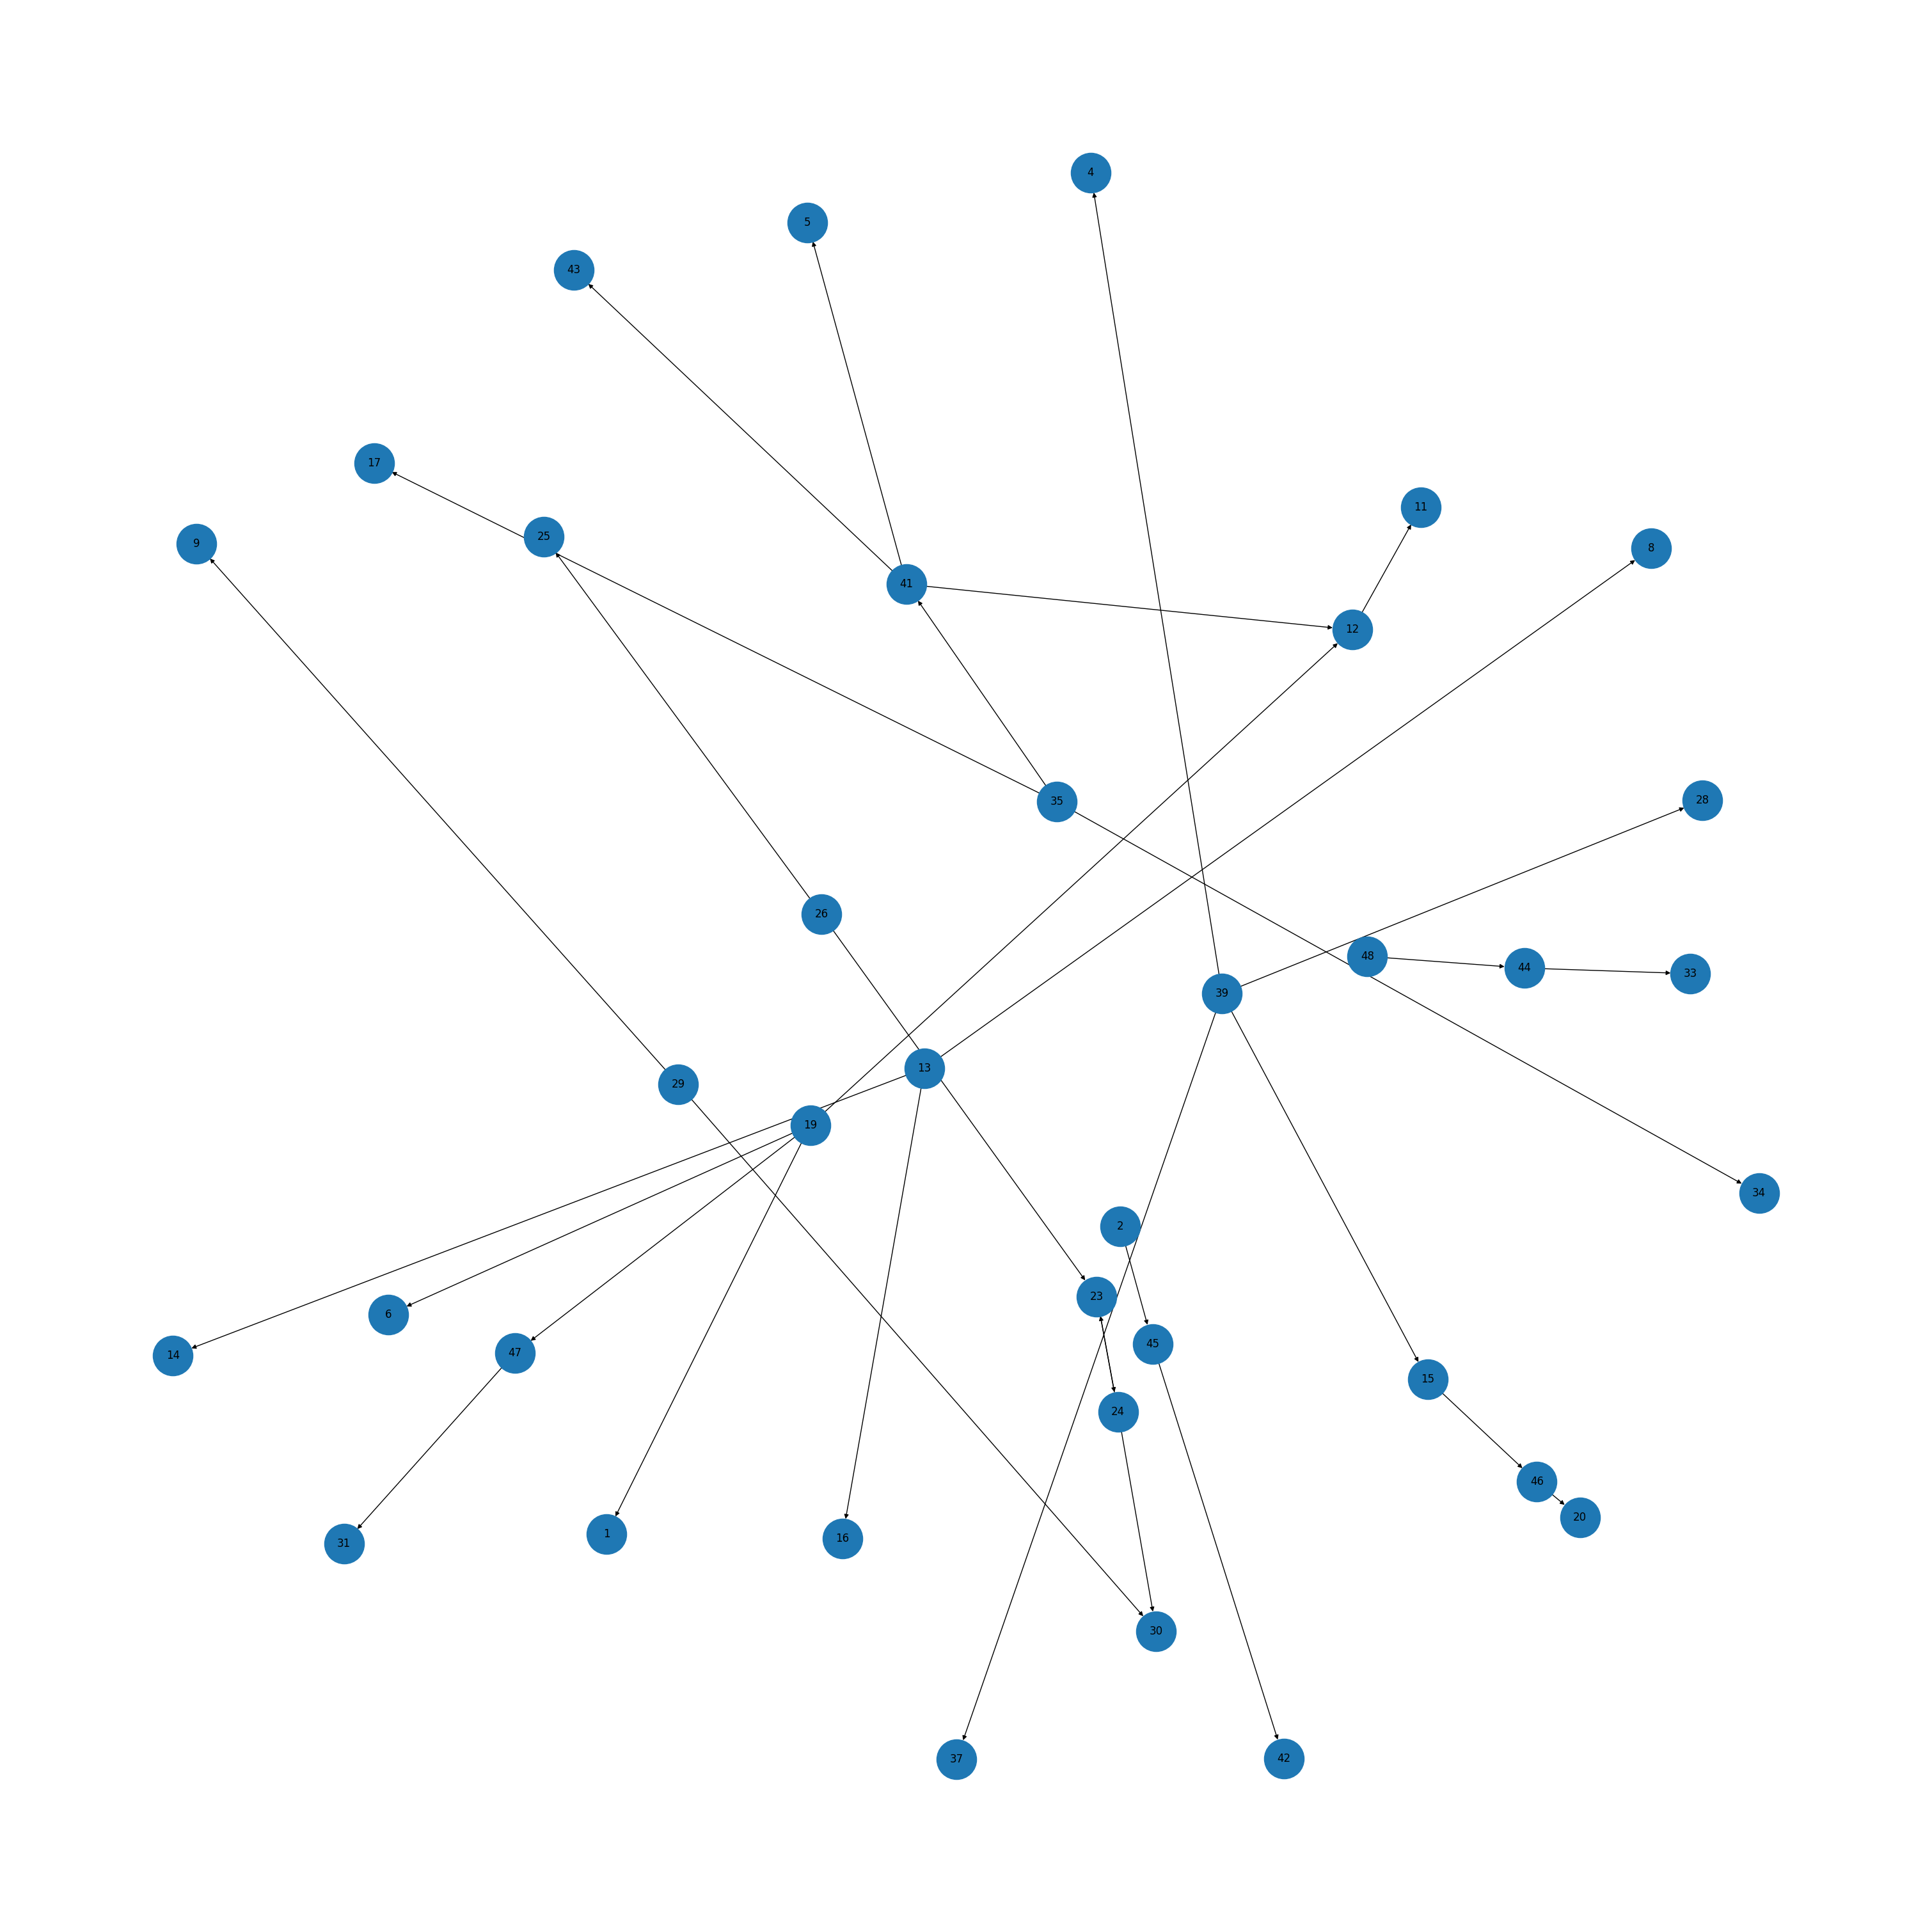

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# plot
pos = nx.spring_layout(temp, k=0.3*1/np.sqrt(len(temp.nodes())), iterations=20)
plt.figure(3, figsize=(30, 30))
nx.draw(temp, pos=pos, node_size=2000)
nx.draw_networkx_labels(temp, pos=pos)
plt.show()

### Here, we convert transmission data into json, then we use 'infection_log'

In [3]:
trans_jason = trans_tree.to_json()
trans_log = trans_jason['infection_log']

transmissions = []  ### records (parent, child, time) 
for i in range(len(trans_log)):
    if trans_log[i]['source'] == None: continue ### this line disregards seed infections as they don't have a parent
    
    temp = [int(trans_log[i]['source']), int(trans_log[i]['target']), int(trans_log[i]['date'])]
    transmissions.append(temp)

In [1]:
##### saving data
import csv
with open('data/transmission_pop_300.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(['Parent', 'Child', 'Origin_time'])
    for i in transmissions:
        spamwriter.writerow([i[0], i[1], i[2]])

NameError: name 'transmissions' is not defined

In [30]:
##### Sort by the last item of each sublist, origin_time, so parents who will appear as a child in the future will get a new
##### name based on its node name and the new time of origin
data = transmissions
sorted_data = sorted(data, key=lambda x: x[-1])

parents = []
for i in sorted_data:
    if i[0] not in parents:
        parents.append(i[0])
    if i[1] in parents:
        i[1] = str(i[1])+'_'+str(i[-1])

In [31]:
##### if 2 enteries have the same child and origin time, in order to have only 1 parent for each node, the first appeared parent 
##### will be taken and the rest will be removed
from collections import defaultdict

# Step 1: Group by the last two items
grouped = defaultdict(list)
for item in sorted_data:
    key = tuple(item[-2:])  # group by last two elements
    grouped[key].append(item)

# Step 2: Keep only one representative from each group
unique_items = [group[0] for group in grouped.values()]

# # Print the cleaned list
# for item in unique_items:
#     print(item)

sorted_data = unique_items

In [32]:
import uuid
from collections import defaultdict

def list_to_newick(edge_list):
    # Step 1: Build children map and origin_times, with duplicate handling
    children = defaultdict(list)
    origin_times = {}
    parent_history = set()

    for parent, child, time in edge_list:
        if child in parent_history and child != parent:
            # Duplicate if child is already a parent
            child = f"{child}_dup_{uuid.uuid4().hex[:6]}"
        parent_history.add(parent)
        children[parent].append(child)
        origin_times[(parent, child)] = float(time)

    # Step 2: Identify roots
    all_parents = set(children.keys())
    all_children = {c for clist in children.values() for c in clist}
    roots = list(all_parents - all_children)

    # Step 3: Add dummy root if needed
    if len(roots) > 1:
        dummy_root = "ROOT"
        for r in roots:
            children[dummy_root].append(r)
            origin_times[(dummy_root, r)] = 0.0
        root = dummy_root
    else:
        root = roots[0]

    # Step 4: Recursive Newick generator
    def to_newick(node):
        if node not in children:
            return f"{node}"
        subtrees = [to_newick(child) + f":{origin_times[(node, child)]}"
                    for child in children[node]]
        return f"({','.join(subtrees)}){node}"

    return to_newick(root) + ";"


In [33]:
from ete3 import Tree

# Example Newick string
newick_str = list_to_newick(sorted_data)

# Load tree
tree = Tree(newick_str, format=1)

# Show the tree in a GUI window
tree.show()


In [12]:
from ete3 import Tree, TreeStyle, TextFace, NodeStyle

# --- 1. Newick string ---
#newick_str = "((D:1.5)B,(E:1.2)C)A;"
newick_str = list_to_newick(sorted_data)
# --- 2. Load the tree ---
tree = Tree(newick_str, format=1)

# --- 3. Style for all nodes ---
def style_all_nodes(tree):
    for node in tree.traverse():
        # Show label on all nodes
        name_face = TextFace(node.name, fsize=10)
        node.add_face(name_face, column=0, position="branch-right")

        # Node style
        nstyle = NodeStyle()
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 10
        nstyle["shape"] = "circle"

        # Color code: leaves = blue, internal = red
        if node.is_leaf():
            nstyle["bgcolor"] = "lightblue"
        else:
            nstyle["bgcolor"] = "lightcoral"

        node.set_style(nstyle)

# --- 4. Tree Style ---
def get_tree_style():
    ts = TreeStyle()
    ts.show_leaf_name = False  # Prevent auto-labeling
    ts.show_branch_length = True
    ts.show_branch_support = False
    ts.scale = 100
    return ts

# Apply styles
style_all_nodes(tree)
tree.show(tree_style=get_tree_style())


In [34]:
from ete3 import Tree, TreeStyle, TextFace

# --- 1. Newick string ---
#newick_str = "((D:1.5)B,(E:1.2)C)A;"

# --- 2. Load the tree ---
tree = Tree(newick_str, format=1)

# --- 3. Add labels to all nodes ---
for node in tree.traverse():
    name_face = TextFace(node.name, fsize=10)
    node.add_face(name_face, column=0, position="branch-right")

# --- 4. Tree style (no color, no auto leaf names) ---
ts = TreeStyle()
ts.show_leaf_name = False  # We manually show labels
ts.show_branch_length = True
ts.show_branch_support = False
ts.branch_vertical_margin = 10
ts.scale = 100

# --- 5. Show the tree ---
tree.show(tree_style=ts)
